### Model Training

Once your model is defined, it can be trained. This can happen on a single thread or on a parallel framework like Watson Machine Learning or Apache Spark. In the most simple case Model Definition and Model Training is just a couple of LOCs (lines of code) away. In the case of Watson Machine Learning or Apache Spark models might need to get serialized and transferred to another technology / framework.

Please specify and justify the technologies used for model definition and training in the ADD. 

Once you think you have achieved a descent model performance save the notebook according to the process model’s naming convention and proceed to the model evaluation task.

In [1]:
!pip install tensorflow
!pip install python-mnist
!pip install Pillow
!pip install pyspark
!pip install scikit-learn

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210624022829-0000
KERNEL_ID = 0ce1c979-00e6-4888-84f3-cb162ef38084
     |████████████████████████████████| 454.3 MB 26 kB/s /s eta 0:00:014 MB 8.1 MB/s eta 0:00:52                    | 59.7 MB 8.1 MB/s eta 0:00:49�█████████▍                 | 203.6 MB 70.3 MB/s eta 0:00:04
     |████████████████████████████████| 42 kB 838 kB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 58.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 20.4 MB/s eta 0:00:01████████████▏                 | 1.8 MB 20.4 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 49.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 53.0 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 54.2 MB/s eta 0:00:01.2 MB 54.2 MB/s eta 0:00:01███████████████████▎            | 8.9 MB 54.2 MB/s eta 0:00:01█████████████▎   | 13.1 MB 54.2 MB/s eta 0:00:01
     |████████████████████

In [2]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
import seaborn as sns
from mnist import MNIST
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.image as mping
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from numpy import asarray
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

tf.__version__

'2.5.0'

In [3]:
PIL.__version__

'8.2.0'

In [4]:
# fire up the spark session
# comment this cell out for a spark server
#sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

#spark = SparkSession \
#    .builder \
#    .getOrCreate()

In [5]:
# enable arrow which lets us transfrom a pandas dataframe into a pyspark dataframe
spark.conf.set("spark.sql.execution.arrow.enabled","true")

## First dataset

#### 60,000 images and 10 classes, each image is 28 x 28 or represented by a 794 element array

In [6]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
!mv train-images-idx3-ubyte.gz?raw=True train-images-idx3-ubyte.gz
!gunzip train-images-idx3-ubyte.gz
!ls -lahr train-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
!mv train-labels-idx1-ubyte.gz?raw=True train-labels-idx1-ubyte.gz
!gunzip train-labels-idx1-ubyte.gz
!ls -lahr train-labels-idx1-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz?raw=True
!mv t10k-images-idx3-ubyte.gz?raw=True t10k-images-idx3-ubyte.gz
!gunzip t10k-images-idx3-ubyte.gz
!ls -lahr t10k-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz?raw=True
!mv t10k-labels-idx1-ubyte.gz?raw=True t10k-labels-idx1-ubyte.gz
!gunzip t10k-labels-idx1-ubyte.gz
!ls -lahr t10k-labels-idx1-ubyte

--2021-06-21 23:08:31--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18165135 (17M)
Saving to: ‘train-images-idx3-ubyte.gz?raw=True’

train-images-idx3-u 100%[===================>]  17.32M  5.94MB/s    in 2.9s    

2021-06-21 23:08:36 (5.94 MB/s) - ‘train-images-idx3-ubyte.gz?raw=True’ saved [18165135/18165135]

-rw-rw-r-- 1 spark spark 45M Feb  4  2019 train-images-idx3-ubyte
--2021-06-21 23:08:39--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29497 (29K)
Saving to: ‘train-labels-idx1-ubyte.gz?raw=True’

train-labels-idx1-u 100

In [7]:
!mkdir kmnistdata
!cp t10k-images-idx3-ubyte kmnistdata/t10k-images-idx3-ubyte
!cp t10k-labels-idx1-ubyte kmnistdata/t10k-labels-idx1-ubyte
!cp train-images-idx3-ubyte kmnistdata/train-images-idx3-ubyte
!cp train-labels-idx1-ubyte kmnistdata/train-labels-idx1-ubyte
!ls -al kmnistdata

data = MNIST('kmnistdata')
train_images, train_labels = data.load_training()
test_images, test_labels = data.load_testing()

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

train_images = train_images / 255
test_images = test_images / 255

total 53908
drwxrwxr-x  2 spark spark     4096 Jun 21 23:08 .
drwxr-xr-x 11 spark  2000     4096 Jun 21 23:08 ..
-rw-rw-r--  1 spark spark  7840016 Jun 21 23:08 t10k-images-idx3-ubyte
-rw-rw-r--  1 spark spark    10008 Jun 21 23:08 t10k-labels-idx1-ubyte
-rw-rw-r--  1 spark spark 47040016 Jun 21 23:08 train-images-idx3-ubyte
-rw-rw-r--  1 spark spark    60008 Jun 21 23:08 train-labels-idx1-ubyte


In [8]:
# model_1 def

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [9]:
# model_1 compile
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# model_1 fit

# began by using 5 epochs here but observed that 
# the validation accuracy is increasing even as we
# stopped training, so consider using more epochs here next

model_1.fit(train_images, train_labels, epochs=5, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4048 - accuracy: 0.8803 - val_loss: 0.5066 - val_accuracy: 0.8456
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1947 - accuracy: 0.9426 - val_loss: 0.4295 - val_accuracy: 0.8718
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1385 - accuracy: 0.9597 - val_loss: 0.3975 - val_accuracy: 0.8907
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1047 - accuracy: 0.9696 - val_loss: 0.4275 - val_accuracy: 0.8801
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0809 - accuracy: 0.9761 - val_loss: 0.3971 - val_accuracy: 0.8982


In [11]:
score = model_1.evaluate(test_images, test_labels, verbose=0)
print('model_1 test loss:', score[0])
print('model_1 test accuracy', score[1])

model_1 test loss: 0.3971461057662964
model_1 test accuracy 0.8981999754905701


In [38]:
# model_1_1 def

model_1_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [39]:
# model_1_1 compile
model_1_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# model_1_1 fit
model_1_1.fit(train_images, train_labels, epochs=5, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4807 - accuracy: 0.8521 - val_loss: 0.5372 - val_accuracy: 0.8344
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2692 - accuracy: 0.9171 - val_loss: 0.4496 - val_accuracy: 0.8587
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2181 - accuracy: 0.9329 - val_loss: 0.4092 - val_accuracy: 0.8790
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1801 - accuracy: 0.9444 - val_loss: 0.3915 - val_accuracy: 0.8871
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1662 - accuracy: 0.9484 - val_loss: 0.3839 - val_accuracy: 0.8890


In [41]:
model_1_1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [52]:
# model_1_2 def

model_1_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [53]:
# model_1_2 compile
model_1_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
# model_1_2 fit
model_1_2.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3722 - accuracy: 0.8857 - val_loss: 0.5198 - val_accuracy: 0.8383
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1791 - accuracy: 0.9460 - val_loss: 0.4599 - val_accuracy: 0.8676
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1261 - accuracy: 0.9617 - val_loss: 0.4123 - val_accuracy: 0.8814
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1046 - accuracy: 0.9681 - val_loss: 0.4151 - val_accuracy: 0.8933
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0839 - accuracy: 0.9747 - val_loss: 0.4230 - val_accuracy: 0.8908
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0675 - accuracy: 0.9791 - val_loss: 0.4180 - val_accuracy: 0.8970
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0614 - accuracy: 0.9805 - val_loss: 0.4154 - val_accuracy:

In [45]:
model_1_2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_37 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_40 (Dense)             (None, 10)                1290      
Total params: 151,306
Trainable params: 151,306
Non-trainable params: 0
_________________________________________________________________


In [49]:
# model_1_3 def

model_1_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [50]:
# model_1_3 compile
model_1_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
# model_1_3 fit
model_1_3.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4513 - accuracy: 0.8613 - val_loss: 0.5261 - val_accuracy: 0.8399
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2188 - accuracy: 0.9348 - val_loss: 0.4477 - val_accuracy: 0.8650
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1648 - accuracy: 0.9506 - val_loss: 0.4268 - val_accuracy: 0.8837
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1326 - accuracy: 0.9604 - val_loss: 0.3916 - val_accuracy: 0.8929
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1138 - accuracy: 0.9666 - val_loss: 0.3983 - val_accuracy: 0.8895
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0943 - accuracy: 0.9714 - val_loss: 0.4388 - val_accuracy: 0.8899
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0860 - accuracy: 0.9750 - val_loss: 0.4374 - val_accuracy:

In [55]:
# model_1_4 def

model_1_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [56]:
# model_1_4 compile

model_1_4.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
# model_1_4 fit

model_1_4.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.2887 - accuracy: 0.1389 - val_loss: 2.2826 - val_accuracy: 0.1397
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2387 - accuracy: 0.2098 - val_loss: 2.2480 - val_accuracy: 0.1768
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.1765 - accuracy: 0.2908 - val_loss: 2.2032 - val_accuracy: 0.2277
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0938 - accuracy: 0.3853 - val_loss: 2.1450 - val_accuracy: 0.2882
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9884 - accuracy: 0.4529 - val_loss: 2.0727 - val_accuracy: 0.3376
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.8645 - accuracy: 0.5017 - val_loss: 1.9919 - val_accuracy: 0.3773
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.7342 - accuracy: 0.5435 - val_loss: 1.9111 - val_accuracy:

In [8]:
# model_1_4_1 def (using the dropouts with adadelta)

model_1_4_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [10]:
# model_1_4_1 compile

model_1_4_1.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# model_1_4_1 fit

model_1_4_1.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/20
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4941 - accuracy: 0.8462 - val_loss: 0.5475 - val_accuracy: 0.8331
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2808 - accuracy: 0.9155 - val_loss: 0.4634 - val_accuracy: 0.8607
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2289 - accuracy: 0.9313 - val_loss: 0.4422 - val_accuracy: 0.8734
Epoch 4/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1979 - accuracy: 0.9408 - val_loss: 0.4326 - val_accuracy: 0.8782
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1789 - accuracy: 0.9456 - val_loss: 0.4243 - val_accuracy: 0.8819
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1636 - accuracy: 0.9510 - val_loss: 0.4209 - val_accuracy: 0.8848
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1542 - accuracy: 0.9545 - val_loss: 0.3964 - val_ac

In [5]:
# model_1_5 def

model_1_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [6]:
# model_1_5 compile

model_1_5.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# model_1_5 fit

model_1_5.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.9446 - accuracy: 0.7149 - val_loss: 0.8656 - val_accuracy: 0.7227
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4174 - accuracy: 0.8721 - val_loss: 0.6876 - val_accuracy: 0.7840
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3243 - accuracy: 0.9013 - val_loss: 0.6232 - val_accuracy: 0.8074
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2668 - accuracy: 0.9203 - val_loss: 0.5939 - val_accuracy: 0.8173
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2259 - accuracy: 0.9320 - val_loss: 0.5436 - val_accuracy: 0.8390
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1958 - accuracy: 0.9427 - val_loss: 0.5060 - val_accuracy: 0.8485
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1698 - accuracy: 0.9505 - val_loss: 0.4889 - val_accuracy:

In [17]:
# model_1_5_1 def

model_1_5_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [18]:
# model_1_5_1 compile

model_1_5_1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# model_1_5_1 fit

model_1_5_1.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/20
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0603 - accuracy: 0.6719 - val_loss: 0.9947 - val_accuracy: 0.6860
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6080 - accuracy: 0.8130 - val_loss: 0.8254 - val_accuracy: 0.7384
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4905 - accuracy: 0.8513 - val_loss: 0.7144 - val_accuracy: 0.7748
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4224 - accuracy: 0.8715 - val_loss: 0.6567 - val_accuracy: 0.7926
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3763 - accuracy: 0.8852 - val_loss: 0.6121 - val_accuracy: 0.8071
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3469 - accuracy: 0.8936 - val_loss: 0.5718 - val_accuracy: 0.8230
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3212 - accuracy: 0.9036 - val_loss: 0.5500 - val_accuracy:

In [13]:
# model_2 def

# optimizer is adam and loss is sparse_categorical_crossentropy

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

x_train = train_images
x_test = test_images
y_train = train_labels
y_test = test_labels

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

model_2 = tf.keras.Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# model_2 compile

model_2.compile(optimizer='adam', 
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

In [ ]:
# fit model

model_2.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 211s 450ms/step - loss: 0.4129 - accuracy: 0.8742 - val_loss: 0.3417 - val_accuracy: 0.9001
Epoch 2/12
469/469 [==============================] - 209s 445ms/step - loss: 0.1737 - accuracy: 0.9475 - val_loss: 0.2736 - val_accuracy: 0.9198
Epoch 3/12
469/469 [==============================] - 208s 443ms/step - loss: 0.1290 - accuracy: 0.9598 - val_loss: 0.2315 - val_accuracy: 0.9371
Epoch 4/12
469/469 [==============================] - 209s 446ms/step - loss: 0.1016 - accuracy: 0.9682 - val_loss: 0.2087 - val_accuracy: 0.9409
Epoch 5/12
469/469 [==============================] - 208s 443ms/step - loss: 0.0820 - accuracy: 0.9740 - val_loss: 0.2093 - val_accuracy: 0.9436
Epoch 6/12
469/469 [==============================] - 208s 443ms/step - loss: 0.0701 - accuracy: 0.9777 - val_loss: 0.2163 - val_accuracy: 0.9427
Epoch 7/12
469/469 [==============================] - 208s 443ms/step - loss: 0.0663 - accuracy: 0.9783 - val_loss: 0.2089 -

In [14]:
# model_2_1 def : change of optimizer to Adadelta and compile

model_2_1 = tf.keras.Sequential()
model_2_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_1.add(Conv2D(64, (3, 3), activation='relu'))
model_2_1.add(MaxPooling2D(pool_size=(2, 2)))
model_2_1.add(Dropout(0.25))
model_2_1.add(tf.keras.layers.Flatten())
model_2_1.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_1.add(Dropout(0.5))
model_2_1.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_2_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
              metrics=['accuracy'])

In [15]:
model_2_1.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 209s 444ms/step - loss: 0.4418 - accuracy: 0.8609 - val_loss: 0.3767 - val_accuracy: 0.8808
Epoch 2/12
469/469 [==============================] - 206s 439ms/step - loss: 0.1749 - accuracy: 0.9479 - val_loss: 0.2798 - val_accuracy: 0.9196
Epoch 3/12
469/469 [==============================] - 206s 439ms/step - loss: 0.1318 - accuracy: 0.9610 - val_loss: 0.2514 - val_accuracy: 0.9303
Epoch 4/12
469/469 [==============================] - 205s 437ms/step - loss: 0.1067 - accuracy: 0.9678 - val_loss: 0.2469 - val_accuracy: 0.9308
Epoch 5/12
469/469 [==============================] - 205s 438ms/step - loss: 0.0929 - accuracy: 0.9725 - val_loss: 0.2341 - val_accuracy: 0.9393
Epoch 6/12
469/469 [==============================] - 205s 438ms/step - loss: 0.0788 - accuracy: 0.9766 - val_loss: 0.2202 - val_accuracy: 0.9429
Epoch 7/12
469/469 [==============================] - 205s 438ms/step - loss: 0.0723 - accuracy: 0.9777 - val_loss: 0.2165 -

In [11]:
# optimizer = Adamax

# model_2_2: change of optimizer to Adamax and compile

model_2_2 = tf.keras.Sequential()
model_2_2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2_2.add(Dropout(0.25))
model_2_2.add(tf.keras.layers.Flatten())
model_2_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_2.add(Dropout(0.5))
model_2_2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_2_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy'])

In [12]:
model_2_2.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 95s 202ms/step - loss: 0.5973 - accuracy: 0.8165 - val_loss: 0.5072 - val_accuracy: 0.8421
Epoch 2/12
469/469 [==============================] - 93s 199ms/step - loss: 0.2788 - accuracy: 0.9162 - val_loss: 0.3876 - val_accuracy: 0.8847
Epoch 3/12
469/469 [==============================] - 94s 200ms/step - loss: 0.2121 - accuracy: 0.9376 - val_loss: 0.3238 - val_accuracy: 0.9056
Epoch 4/12
469/469 [==============================] - 93s 199ms/step - loss: 0.1723 - accuracy: 0.9477 - val_loss: 0.3036 - val_accuracy: 0.9139
Epoch 5/12
469/469 [==============================] - 94s 200ms/step - loss: 0.1514 - accuracy: 0.9544 - val_loss: 0.2632 - val_accuracy: 0.9246
Epoch 6/12
469/469 [==============================] - 94s 200ms/step - loss: 0.1321 - accuracy: 0.9598 - val_loss: 0.2511 - val_accuracy: 0.9304
Epoch 7/12
469/469 [==============================] - 93s 198ms/step - loss: 0.1150 - accuracy: 0.9647 - val_loss: 0.2460 - val_ac

In [14]:
# optimizer = Adagrad

# model_2_3: change of optimizer to Adagrad and compile

model_2_3 = tf.keras.Sequential()
model_2_3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_3.add(Conv2D(64, (3, 3), activation='relu'))
model_2_3.add(MaxPooling2D(pool_size=(2, 2)))
model_2_3.add(Dropout(0.25))
model_2_3.add(tf.keras.layers.Flatten())
model_2_3.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_3.add(Dropout(0.5))
model_2_3.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_2_3.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adagrad',
              metrics=['accuracy'])

In [15]:
model_2_3.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 214s 455ms/step - loss: 2.0159 - accuracy: 0.3416 - val_loss: 1.6746 - val_accuracy: 0.5227
Epoch 2/12
469/469 [==============================] - 213s 454ms/step - loss: 1.1844 - accuracy: 0.6353 - val_loss: 1.2752 - val_accuracy: 0.6165
Epoch 3/12
469/469 [==============================] - 211s 450ms/step - loss: 0.9188 - accuracy: 0.7169 - val_loss: 1.1081 - val_accuracy: 0.6604
Epoch 4/12
469/469 [==============================] - 213s 454ms/step - loss: 0.8054 - accuracy: 0.7503 - val_loss: 1.0051 - val_accuracy: 0.6873
Epoch 5/12
469/469 [==============================] - 212s 452ms/step - loss: 0.7404 - accuracy: 0.7710 - val_loss: 0.9493 - val_accuracy: 0.7028
Epoch 6/12
469/469 [==============================] - 212s 451ms/step - loss: 0.6963 - accuracy: 0.7845 - val_loss: 0.8988 - val_accuracy: 0.7176
Epoch 7/12
469/469 [==============================] - 213s 453ms/step - loss: 0.6649 - accuracy: 0.7959 - val_loss: 0.8592 -

In [16]:
# optimizer = Nadam

# model_2_4: change of optimizer to Nadam and compile

model_2_4 = tf.keras.Sequential()
model_2_4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_4.add(Conv2D(64, (3, 3), activation='relu'))
model_2_4.add(MaxPooling2D(pool_size=(2, 2)))
model_2_4.add(Dropout(0.25))
model_2_4.add(tf.keras.layers.Flatten())
model_2_4.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_4.add(Dropout(0.5))
model_2_4.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_2_4.compile(loss='sparse_categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])

In [17]:
model_2_4.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 97s 206ms/step - loss: 0.4006 - accuracy: 0.8765 - val_loss: 0.3753 - val_accuracy: 0.8869
Epoch 2/12
469/469 [==============================] - 95s 203ms/step - loss: 0.1686 - accuracy: 0.9496 - val_loss: 0.2696 - val_accuracy: 0.9219
Epoch 3/12
469/469 [==============================] - 95s 204ms/step - loss: 0.1271 - accuracy: 0.9604 - val_loss: 0.2380 - val_accuracy: 0.9340
Epoch 4/12
469/469 [==============================] - 96s 204ms/step - loss: 0.0979 - accuracy: 0.9690 - val_loss: 0.2271 - val_accuracy: 0.9407
Epoch 5/12
469/469 [==============================] - 96s 204ms/step - loss: 0.0836 - accuracy: 0.9736 - val_loss: 0.2184 - val_accuracy: 0.9427
Epoch 6/12
469/469 [==============================] - 96s 204ms/step - loss: 0.0676 - accuracy: 0.9787 - val_loss: 0.1975 - val_accuracy: 0.9490
Epoch 7/12
469/469 [==============================] - 96s 204ms/step - loss: 0.0602 - accuracy: 0.9804 - val_loss: 0.2283 - val_ac

#### This is the first dataset in .npz format

In [15]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz?raw=True
!mv kmnist-train-imgs.npz?raw=True kmnist-train-imgs.npz
!ls -lahr kmnist-train-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz?raw=True
!mv kmnist-train-labels.npz?raw=True kmnist-train-labels.npz
!ls -lahr kmnist-train-labels.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz?raw=True
!mv kmnist-test-imgs.npz?raw=True kmnist-test-imgs.npz
!ls -lahr kmnist-test-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz?raw=True
!mv kmnist-test-labels.npz?raw=True kmnist-test-labels.npz
!ls -lahr kmnist-test-labels.npz

--2021-06-11 17:21:46--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18384171 (18M)
Saving to: ‘kmnist-train-imgs.npz?raw=True’

kmnist-train-imgs.n 100%[===================>]  17.53M  4.25MB/s    in 4.9s    

2021-06-11 17:21:52 (3.61 MB/s) - ‘kmnist-train-imgs.npz?raw=True’ saved [18384171/18384171]

-rw-rw-r-- 1 spark spark 18M Feb  4  2019 kmnist-train-imgs.npz
--2021-06-11 17:21:54--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29700 (29K)
Saving to: ‘kmnist-train-labels.npz?raw=True’

kmnist-train-labels 100%[===================>]

### Model:  K Nearest Neighbors

In [16]:
def load(f):
    return np.load(f)['arr_0']

In [17]:
x_train = load('kmnist-train-imgs.npz')
y_train = load('kmnist-train-labels.npz')
x_test = load('kmnist-test-imgs.npz')
y_test = load('kmnist-test-labels.npz')

In [18]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [19]:
model_3 = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
print('Fit', model_3)
model_3.fit(x_train, y_train)

Fit KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')


KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [20]:
print('Evaluate', model_3)
score = model_3.score(x_test, y_test)
print('The accuracy is:', score)

Evaluate KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')
The accuracy is: 0.921


### Model: K Nearest Neighbors with Principal Component Analysis dimensionality reduction

In [ ]:
# KNN with dim reduction:  the code is currently broken, skip this for now

pca = PCA(n_components=60, random_state=0)

In [ ]:
x_train = pca.fit_transform(x_train)
x_test = pca.transform

In [ ]:
model_4 = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
print('Fit', model_4)
model_4.fit(x_train, y_train)

In [ ]:
print('Evaluate', model_4)
score = model_4.score(x_test, y_test)
print('The accuracy is:', score)

## Second dataset

#### 232,365 images, 49 classes, each image is 28 x 28 or represented by a 794 element array

In [17]:
# download the train and test labels and images, 
# which are available onlyh in .npz format 

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
!mv k49-train-imgs.npz?raw=True k49-train-imgs.npz
!ls -lahr k49-train-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
!mv k49-train-labels.npz?raw=True k49-train-labels.npz
!ls -lahr k49-train-labels.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz?raw=True
!mv k49-test-imgs.npz?raw=True k49-test-imgs.npz
!ls -lahr k49-test-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz?raw=True
!mv k49-test-labels.npz?raw=True k49-test-labels.npz
!ls -lahr k49-test-labels.npz

--2021-06-21 23:59:46--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66117696 (63M)
Saving to: ‘k49-train-imgs.npz?raw=True’

k49-train-imgs.npz? 100%[===================>]  63.05M  3.18MB/s    in 20s     

2021-06-22 00:00:07 (3.14 MB/s) - ‘k49-train-imgs.npz?raw=True’ saved [66117696/66117696]

-rw-rw-r-- 1 spark spark 64M Feb  4  2019 k49-train-imgs.npz
--2021-06-22 00:00:09--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164485 (161K)
Saving to: ‘k49-train-labels.npz?raw=True’

k49-train-labels.np 100%[===================>] 160.63K   383KB/s    

In [18]:
def load(f):
    return np.load(f)['arr_0']

In [19]:
x_train_k49 = load('k49-train-imgs.npz')
y_train_k49 = load('k49-train-labels.npz')
x_test_k49 = load('k49-test-imgs.npz')
y_test_k49 = load('k49-test-labels.npz')

x_train_k49 = x_train_k49.reshape(-1, 784)
x_test_k49 = x_test_k49.reshape(-1, 784)


# the numpy arrays used in the keras models need to be between 0 and 1
# we keep x_train_k49 and x_test_k49 in the format of between 0 and 255
# for use in the K-nearest Neighbors model below

train_images_k49 = x_train_k49 / 255
test_images_k49 = x_test_k49 / 255

# and the labels can be the same

train_labels_k49 = y_train_k49
test_labels_k49 = y_test_k49

In [9]:
# model_1_k49 def
# we have to change the last layer due to the 49 categories

model_1_k49 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(49, activation=tf.nn.softmax)
])

In [10]:
# model_1_k49 compile
model_1_k49.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# model_1_k49 fit
# as in the first data set, this model could probably use more epochs
model_1_k49.fit(train_images_k49, train_labels_k49, epochs=5, verbose=1, validation_data=(test_images_k49, test_labels_k49))

Epoch 1/5
7262/7262 [==============================] - 14s 2ms/step - loss: 0.9142 - accuracy: 0.7662 - val_loss: 1.0799 - val_accuracy: 0.7278
Epoch 2/5
7262/7262 [==============================] - 13s 2ms/step - loss: 0.5710 - accuracy: 0.8474 - val_loss: 0.9618 - val_accuracy: 0.7581
Epoch 3/5
7262/7262 [==============================] - 13s 2ms/step - loss: 0.4910 - accuracy: 0.8670 - val_loss: 0.9151 - val_accuracy: 0.7734
Epoch 4/5
7262/7262 [==============================] - 13s 2ms/step - loss: 0.4495 - accuracy: 0.8786 - val_loss: 0.9089 - val_accuracy: 0.7800
Epoch 5/5
7262/7262 [==============================] - 13s 2ms/step - loss: 0.4226 - accuracy: 0.8843 - val_loss: 0.9129 - val_accuracy: 0.7817


In [9]:
# model_1_2_k49 def

model_1_2_k49 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(49, activation=tf.nn.softmax)
])

In [10]:
# model_1_2_k49 compile
model_1_2_k49.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# model_1_2_k49 fit
model_1_2_k49.fit(train_images_k49, train_labels_k49, epochs=20, verbose=1, validation_data=(test_images_k49, test_labels_k49))

Epoch 1/20
7262/7262 [==============================] - 17s 2ms/step - loss: 0.8359 - accuracy: 0.7735 - val_loss: 0.9507 - val_accuracy: 0.7440
Epoch 2/20
7262/7262 [==============================] - 16s 2ms/step - loss: 0.5021 - accuracy: 0.8600 - val_loss: 0.8355 - val_accuracy: 0.7785
Epoch 3/20
7262/7262 [==============================] - 16s 2ms/step - loss: 0.4239 - accuracy: 0.8810 - val_loss: 0.7762 - val_accuracy: 0.7992
Epoch 4/20
7262/7262 [==============================] - 16s 2ms/step - loss: 0.3812 - accuracy: 0.8923 - val_loss: 0.7687 - val_accuracy: 0.8008
Epoch 5/20
7262/7262 [==============================] - 16s 2ms/step - loss: 0.3527 - accuracy: 0.8997 - val_loss: 0.7548 - val_accuracy: 0.8121
Epoch 6/20
7262/7262 [==============================] - 17s 2ms/step - loss: 0.3314 - accuracy: 0.9058 - val_loss: 0.7723 - val_accuracy: 0.8113
Epoch 7/20
7262/7262 [==============================] - 16s 2ms/step - loss: 0.3148 - accuracy: 0.9100 - val_loss: 0.7624 - val_ac

In [21]:
model_1_2_k49.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 49)                6321      
Total params: 156,337
Trainable params: 156,337
Non-trainable params: 0
_________________________________________________________________


In [9]:
# model_1_5_k49 def

model_1_5_k49 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(49, activation=tf.nn.softmax)
])

In [10]:
# model_1_5_k49 compile

model_1_5_k49.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# model_1_5_k49 fit

model_1_5_k49.fit(train_images_k49, train_labels_k49, epochs=20, verbose=1, validation_data=(test_images_k49, test_labels_k49))

Epoch 1/20
7262/7262 [==============================] - 15s 2ms/step - loss: 1.7135 - accuracy: 0.5690 - val_loss: 1.5775 - val_accuracy: 0.6086
Epoch 2/20
7262/7262 [==============================] - 14s 2ms/step - loss: 0.8724 - accuracy: 0.7705 - val_loss: 1.2330 - val_accuracy: 0.6849
Epoch 3/20
7262/7262 [==============================] - 14s 2ms/step - loss: 0.6760 - accuracy: 0.8188 - val_loss: 1.0666 - val_accuracy: 0.7251
Epoch 4/20
7262/7262 [==============================] - 14s 2ms/step - loss: 0.5714 - accuracy: 0.8449 - val_loss: 0.9663 - val_accuracy: 0.7480
Epoch 5/20
7262/7262 [==============================] - 14s 2ms/step - loss: 0.5047 - accuracy: 0.8612 - val_loss: 0.8925 - val_accuracy: 0.7698
Epoch 6/20
7262/7262 [==============================] - 14s 2ms/step - loss: 0.4553 - accuracy: 0.8747 - val_loss: 0.8496 - val_accuracy: 0.7793
Epoch 7/20
7262/7262 [==============================] - 14s 2ms/step - loss: 0.4175 - accuracy: 0.8841 - val_loss: 0.8400 - val_ac

In [12]:
# model_1_5_k49 fit

model_1_5_k49.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 49)                6321      
Total params: 156,337
Trainable params: 156,337
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model_2_k49 def

batch_size = 128
num_classes = 49       #  here we specify the number of classes as 49 instead of 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

x_train = train_images_k49
x_test = test_images_k49
y_train = train_labels_k49
y_test = test_labels_k49

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

model_2_k49 = tf.keras.Sequential()
model_2_k49.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_k49.add(Conv2D(64, (3, 3), activation='relu'))
model_2_k49.add(MaxPooling2D(pool_size=(2, 2)))
model_2_k49.add(Dropout(0.25))
model_2_k49.add(tf.keras.layers.Flatten())
model_2_k49.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_k49.add(Dropout(0.5))
model_2_k49.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# model_2 compile

model_2_k49.compile(optimizer='adam', 
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

In [13]:
# fit model2_k49

model_2_k49.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_test, y_test))

Epoch 1/12
1816/1816 [==============================] - 342s 188ms/step - loss: 0.9383 - accuracy: 0.7530 - val_loss: 0.6622 - val_accuracy: 0.8259
Epoch 2/12
1816/1816 [==============================] - 340s 187ms/step - loss: 0.5146 - accuracy: 0.8584 - val_loss: 0.5186 - val_accuracy: 0.8644
Epoch 3/12
1816/1816 [==============================] - 338s 186ms/step - loss: 0.4178 - accuracy: 0.8831 - val_loss: 0.4378 - val_accuracy: 0.8841
Epoch 4/12
1816/1816 [==============================] - 338s 186ms/step - loss: 0.3619 - accuracy: 0.8981 - val_loss: 0.3942 - val_accuracy: 0.8978
Epoch 5/12
1816/1816 [==============================] - 336s 185ms/step - loss: 0.3248 - accuracy: 0.9068 - val_loss: 0.3849 - val_accuracy: 0.9000
Epoch 6/12
1816/1816 [==============================] - 336s 185ms/step - loss: 0.2997 - accuracy: 0.9139 - val_loss: 0.3704 - val_accuracy: 0.9067
Epoch 7/12
1816/1816 [==============================] - 335s 185ms/step - loss: 0.2788 - accuracy: 0.9189 - val_

In [21]:
# model_2_1_k49 def

batch_size = 128
num_classes = 49       #  here we specify the number of classes as 49 instead of 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

x_train = train_images_k49
x_test = test_images_k49
y_train = train_labels_k49
y_test = test_labels_k49

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

model_2_1_k49 = tf.keras.Sequential()
model_2_1_k49.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_1_k49.add(Conv2D(64, (3, 3), activation='relu'))
model_2_1_k49.add(MaxPooling2D(pool_size=(2, 2)))
model_2_1_k49.add(Dropout(0.25))
model_2_1_k49.add(tf.keras.layers.Flatten())
model_2_1_k49.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_1_k49.add(Dropout(0.5))
model_2_1_k49.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [22]:
# change of optimizer and compile model_2_k49

model_2_1_k49.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
              metrics=['accuracy'])

In [23]:
# fit model_2_k49 after change of optmizer

model_2_1_k49.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
1816/1816 [==============================] - 802s 441ms/step - loss: 0.9429 - accuracy: 0.7522 - val_loss: 0.6710 - val_accuracy: 0.8271
Epoch 2/12
1816/1816 [==============================] - 797s 439ms/step - loss: 0.5117 - accuracy: 0.8620 - val_loss: 0.5405 - val_accuracy: 0.8605
Epoch 3/12
1816/1816 [==============================] - 798s 439ms/step - loss: 0.4224 - accuracy: 0.8848 - val_loss: 0.4838 - val_accuracy: 0.8779
Epoch 4/12
1816/1816 [==============================] - 794s 437ms/step - loss: 0.3805 - accuracy: 0.8967 - val_loss: 0.4518 - val_accuracy: 0.8836
Epoch 5/12
1816/1816 [==============================] - 796s 438ms/step - loss: 0.3546 - accuracy: 0.9041 - val_loss: 0.4339 - val_accuracy: 0.8913
Epoch 6/12
1816/1816 [==============================] - 796s 438ms/step - loss: 0.3443 - accuracy: 0.9083 - val_loss: 0.4129 - val_accuracy: 0.8940
Epoch 7/12
1816/1816 [==============================] - 798s 439ms/step - loss: 0.3346 - accuracy: 0.9110 - val_

### Model:  K Nearest Neighbors - k49

In [16]:
# recall that the two numpy image arrays used below, namely x_train_k49 and x_test_k49
# are arrays of integers, which works fine for KNN

In [17]:
model_3_k49 = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
print('Fit', model_3_k49)
model_3_k49.fit(x_train_k49, y_train_k49)

Fit KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')


KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [ ]:
print('Evaluate', model_3_k49)
score = model_3_k49.score(x_test_k49, y_test_k49)
print('The accuracy is:', score)

Evaluate KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')


### The Third Dataset

#### Includes Kanji characters, this data has 3832 different classes and consists of 140,426 images, each image is 64 X 64 pixels
#### This dataset is not as processed as the other two. It is just a bunch of png images in a directory inside an archive file.

In [6]:
# we download the archive:

!wget http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
!mv kkanji.tar?raw=True kkanji.tar
!ls -lahr kkanji.tar

# list the contents of the archive
# limit output to the first 70 files

!tar -tf kkanji.tar | head -70

--2021-06-24 02:32:15--  http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324290560 (309M) [application/x-tar]
Saving to: ‘kkanji.tar?raw=True’

kkanji.tar?raw=True 100%[===================>] 309.27M  6.87MB/s    in 46s     

2021-06-24 02:33:03 (6.79 MB/s) - ‘kkanji.tar?raw=True’ saved [324290560/324290560]

-rw-rw-r-- 1 spark spark 310M Dec  8  2018 kkanji.tar
kkanji2/
kkanji2/U+5B87/
kkanji2/U+5B87/72d56fcb33d10fe0.png
kkanji2/U+5B87/75f7923797777c74.png
kkanji2/U+5B87/69d6becd4f8f2d61.png
kkanji2/U+5B87/522dd01c5f9573f5.png
kkanji2/U+5B87/36aadd8d92c64049.png
kkanji2/U+5B87/58f75629e53b9e63.png
kkanji2/U+5B87/557950fbb39b019b.png
kkanji2/U+5B87/c4ca643dbc0299b6.png
kkanji2/U+5B87/02f161e7e7a3c364.png
kkanji2/U+5B87/c45553bb4a35c8d4.png
kkanji2/U+5B87/ffa955bd6cb43af8.png
kk

In [7]:
# extract the archive:
!tar -xf kkanji.tar

In [8]:
# put the codepoints in a file
# let the first line of the file be name
# of the column in the dataframe we are creating
!echo codepoint > codepoints.csv
!ls kkanji2 >> codepoints.csv

In [9]:
# verify the file's path:
print (os.path.abspath("codepoints.csv"))

/home/spark/shared/codepoints.csv


In [10]:
# read all the lines of the file into pandas dataframe
# including the column header which is already in the file
# display new dataframe
# here we can confirm that the data has 3832 classes

df_kanji_classmap = pd.read_csv("codepoints.csv")
df_kanji_classmap

,codepoint
0,U+241C6
1,U+24FA3
2,U+25DA1
3,U+27752
4,U+29780
...,...
3827,U+FA38
3828,U+FA45
3829,U+FA4A
3830,U+FA55


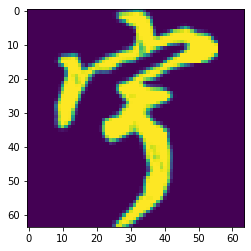

In [11]:
# we'll need to read the images in to transform them
#read the first listed image in the first folder and display it
img = mping.imread('kkanji2/U+5B87/72d56fcb33d10fe0.png')
plt.imshow(img)
plt.show()
# note that this image in only "first" as listed from the tar arcive above
# it is not "first" in terms of the codepoint listing we created directly above

In [12]:
# create a pandas dataframe that contains the codepoint for each image, 
# and its full path in the os and display that dataframe

#  ** reminder:  makes sure to set the path line correctly using the fact that
# the directory kkanji2 is in the same directory as the file codepoints.csv

data = []
dir = os.path.realpath('/home/spark/shared/kkanji2')
for r, d, f in os.walk(dir):
    for file in f:
        if ".png" in file:
            data.append((r.split('/')[-1],os.path.join(r,file)))
df_kanji2 = pd.DataFrame(data, columns=['codepoint', 'image_file_path']).sort_values(by=['codepoint'], ignore_index = True)

,codepoint,image_file_path
0,U+241C6,/home/spark/shared/kkanji2/U+241C6/c0d603c6ce4a4538.png
1,U+241C6,/home/spark/shared/kkanji2/U+241C6/689fa55040ec4f03.png
2,U+24FA3,/home/spark/shared/kkanji2/U+24FA3/4190e728bfc948e0.png
3,U+24FA3,/home/spark/shared/kkanji2/U+24FA3/80582798ed70ce7c.png
4,U+25DA1,/home/spark/shared/kkanji2/U+25DA1/512d7fcacddd25fd.png
...,...,...
140419,U+FA55,/home/spark/shared/kkanji2/U+FA55/f03dee341d017a83.png
140420,U+FA55,/home/spark/shared/kkanji2/U+FA55/9bb329908332c929.png
140421,U+FA55,/home/spark/shared/kkanji2/U+FA55/9158bbb254b2ec88.png
140422,U+FA5C,/home/spark/shared/kkanji2/U+FA5C/15e2060396eba2b3.png


'/home/spark/shared/kkanji2/U+241C6/c0d603c6ce4a4538.png'

PNG
(64, 64)
L


float32


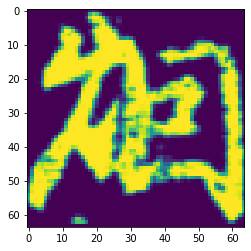

<class 'numpy.ndarray'>
(64, 64)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.6156863 , 0.07058824,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0627451 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

(64, 64)

In [13]:
# add a blank column to the dataframe with column name 'np_array'

df_kanji2['np_array'] = ""
df_kanji2

,codepoint,image_file_path,np_array
0,U+241C6,/home/spark/shared/kkanji2/U+241C6/c0d603c6ce4...,
1,U+241C6,/home/spark/shared/kkanji2/U+241C6/689fa55040e...,
2,U+24FA3,/home/spark/shared/kkanji2/U+24FA3/4190e728bfc...,
3,U+24FA3,/home/spark/shared/kkanji2/U+24FA3/80582798ed7...,
4,U+25DA1,/home/spark/shared/kkanji2/U+25DA1/512d7fcacdd...,
...,...,...,...
140419,U+FA55,/home/spark/shared/kkanji2/U+FA55/f03dee341d01...,
140420,U+FA55,/home/spark/shared/kkanji2/U+FA55/9bb329908332...,
140421,U+FA55,/home/spark/shared/kkanji2/U+FA55/9158bbb254b2...,
140422,U+FA5C,/home/spark/shared/kkanji2/U+FA5C/15e2060396eb...,


In [14]:
# convert the pandas dataframe into a pyspark dataframe
df_kanji2_pyspk = spark.createDataFrame(df_kanji2)

In [15]:
# our data has 3,831 different classes each with unique string names
# which is based on their character codepoints
# but we want simple numeric class index
# so we instantiate a StringIndexer in spark:

indexer = StringIndexer(inputCol="codepoint",outputCol="classIndex")
indexed_df = indexer.fit(df_kanji2_pyspk).transform(df_kanji2_pyspk)
indexed_df.show()

+---------+--------------------+--------+----------+
|codepoint|     image_file_path|np_array|classIndex|
+---------+--------------------+--------+----------+
|  U+241C6|/home/spark/share...|        |    2606.0|
|  U+241C6|/home/spark/share...|        |    2606.0|
|  U+24FA3|/home/spark/share...|        |    2607.0|
|  U+24FA3|/home/spark/share...|        |    2607.0|
|  U+25DA1|/home/spark/share...|        |    3017.0|
|  U+27752|/home/spark/share...|        |    1966.0|
|  U+27752|/home/spark/share...|        |    1966.0|
|  U+27752|/home/spark/share...|        |    1966.0|
|  U+27752|/home/spark/share...|        |    1966.0|
|  U+27752|/home/spark/share...|        |    1966.0|
|  U+29780|/home/spark/share...|        |    3018.0|
|  U+29DDA|/home/spark/share...|        |    3019.0|
|  U+29E75|/home/spark/share...|        |    3020.0|
|   U+4093|/home/spark/share...|        |    3021.0|
|   U+4453|/home/spark/share...|        |     680.0|
|   U+4453|/home/spark/share...|        |     

In [16]:
# transform back to pandas dataframe:
df_kanji2 = indexed_df.toPandas()
df_kanji2

,codepoint,image_file_path,np_array,classIndex
0,U+241C6,/home/spark/shared/kkanji2/U+241C6/c0d603c6ce4...,,2606.0
1,U+241C6,/home/spark/shared/kkanji2/U+241C6/689fa55040e...,,2606.0
2,U+24FA3,/home/spark/shared/kkanji2/U+24FA3/4190e728bfc...,,2607.0
3,U+24FA3,/home/spark/shared/kkanji2/U+24FA3/80582798ed7...,,2607.0
4,U+25DA1,/home/spark/shared/kkanji2/U+25DA1/512d7fcacdd...,,3017.0
...,...,...,...,...
140419,U+FA55,/home/spark/shared/kkanji2/U+FA55/f03dee341d01...,,1041.0
140420,U+FA55,/home/spark/shared/kkanji2/U+FA55/9bb329908332...,,1041.0
140421,U+FA55,/home/spark/shared/kkanji2/U+FA55/9158bbb254b2...,,1041.0
140422,U+FA5C,/home/spark/shared/kkanji2/U+FA5C/15e2060396eb...,,3016.0


In [17]:
# add a column containing and numpy array of the image indicated in the path in image_file_path
# and at the same time, flatten each image from a 64 x 64 numpy array to a single
# dimension 4096 element long numpy array, and normalize it
df_kanji2['np_array'] = df_kanji2['image_file_path'].apply(lambda x: np.asarray(Image.open(x))).apply(lambda y: np.reshape(y,(4096,)))

In [18]:
df_kanji2

,codepoint,image_file_path,np_array,classIndex
0,U+241C6,/home/spark/shared/kkanji2/U+241C6/c0d603c6ce4...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2606.0
1,U+241C6,/home/spark/shared/kkanji2/U+241C6/689fa55040e...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2606.0
2,U+24FA3,/home/spark/shared/kkanji2/U+24FA3/4190e728bfc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2607.0
3,U+24FA3,/home/spark/shared/kkanji2/U+24FA3/80582798ed7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2607.0
4,U+25DA1,/home/spark/shared/kkanji2/U+25DA1/512d7fcacdd...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3017.0
...,...,...,...,...
140419,U+FA55,/home/spark/shared/kkanji2/U+FA55/f03dee341d01...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1041.0
140420,U+FA55,/home/spark/shared/kkanji2/U+FA55/9bb329908332...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 2,...",1041.0
140421,U+FA55,/home/spark/shared/kkanji2/U+FA55/9158bbb254b2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1041.0
140422,U+FA5C,/home/spark/shared/kkanji2/U+FA5C/15e2060396eb...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3016.0


In [19]:
images_kanji = df_kanji2["np_array"].to_numpy()
labels_kanji = df_kanji2["classIndex"].to_numpy()

In [20]:
images_kanji = np.stack(images_kanji)

In [21]:
images_kanji.shape

(140424, 4096)

In [22]:
labels_kanji.shape

(140424,)

In [23]:
x_train_kanji, x_test_kanji, y_train_kanji, y_test_kanji = train_test_split(images_kanji, labels_kanji, test_size = 0.2, random_state=42)

In [24]:
# we need to normalize the numpy arrays so that each number in the numpy
# array is between 0 and 1:

x_train_kanji =  x_train_kanji / 255
x_test_kanji = x_test_kanji / 255

In [25]:
# model_1_2_k def

model_1_2_k = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),    
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),    
    tf.keras.layers.Dense(3832, activation=tf.nn.softmax)
])

In [26]:
# model_1_2_k compile
model_1_2_k.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# model_1_2_k fit
model_1_2_k.fit(x_train_kanji, y_train_kanji, epochs=12, verbose=1, validation_data=(x_test_kanji, y_test_kanji))